In [2]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
ip = "192.168.4.205"
duckdb.sql("INSTALL postgres;")
duckdb.sql("LOAD postgres;")
duckdb.sql(f"ATTACH 'dbname=postgres user=postgres host={ip} password=template!PWD' AS db (TYPE POSTGRES);")


AMD Ryzen 5 5600G 4.46GHz

Intel N100 

Text(0.5, 1.0, 'Time vs Generation')

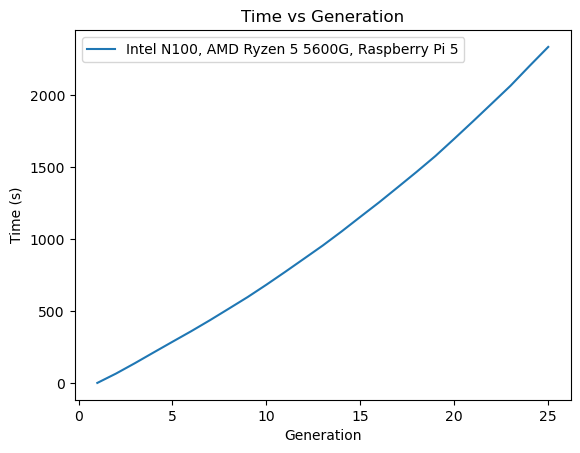

In [7]:
df = duckdb.query("""
SELECT * FROM db.public.time_monitor
""").df()

df["time_elapsed"] = df['time'] - df['time'].min()

plt.plot(df['generation'], df['time_elapsed'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")
plt.ylabel("Time (s)")
plt.xlabel("Generation")
plt.legend()
plt.title("Time vs Generation")


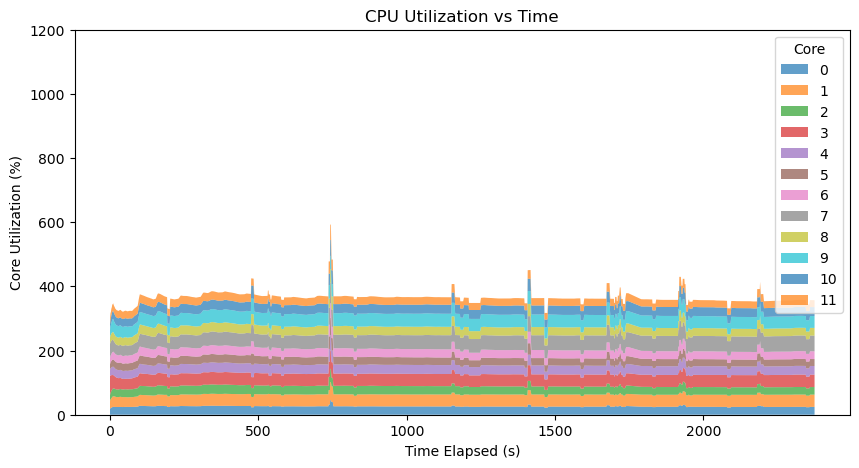

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


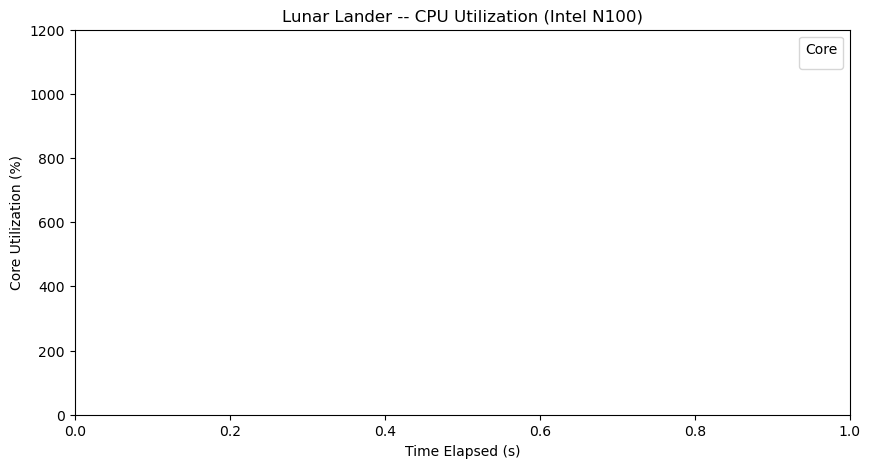

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


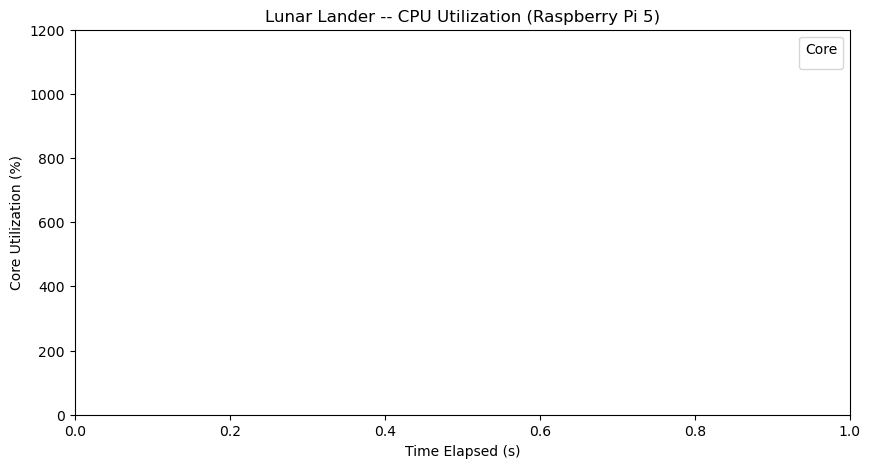

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from scipy.ndimage import gaussian_filter1d

# Define the workers you want to plot
workers = ['desktop', 'beelink', 'raspberrypi']

# Define smoothing function
def smooth_data(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# Plotting for each worker
for worker in workers:
    # Query and prepare the data
    df = duckdb.query(f"""
    SELECT * FROM db.public.cpu_utilization
    WHERE worker = '{worker}'
    """).df()

    # Calculate time elapsed
    df['time_elapsed'] = df['time'] - df['time'].min()

    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(index='time_elapsed', columns='core', values='utilization', aggfunc='mean')

    # Smooth the data
    window_size = 5  # Adjust window size as needed
    smoothed_df = pivot_df.apply(lambda x: smooth_data(pd.Series(x), window_size))

    # Create a new figure for each worker
    plt.figure(figsize=(10, 5))

    # Plotting
    if worker == "desktop":
        plt.stackplot(smoothed_df.index, smoothed_df.T, labels=smoothed_df.columns, alpha=0.7)

    
    # Set title based on worker type
    if worker == "desktop":
        plt.title(f'CPU Utilization vs Time')
    elif worker == "beelink":
        plt.title(f'Lunar Lander -- CPU Utilization (Intel N100)')
    elif worker == "raspberrypi":
        plt.title(f'Lunar Lander -- CPU Utilization (Raspberry Pi 5)')
    elif worker == "macbook":
        plt.title(f"CPU Utilization (Apple M1)")

    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Core Utilization (%)')
    plt.ylim(0, 1200)
    plt.legend(title='Core')

    plt.show()
    # Save the figure
    plt.savefig(f"./figures/cpu_utilization_{worker}.png")
    
    # Close the figure
    plt.close()


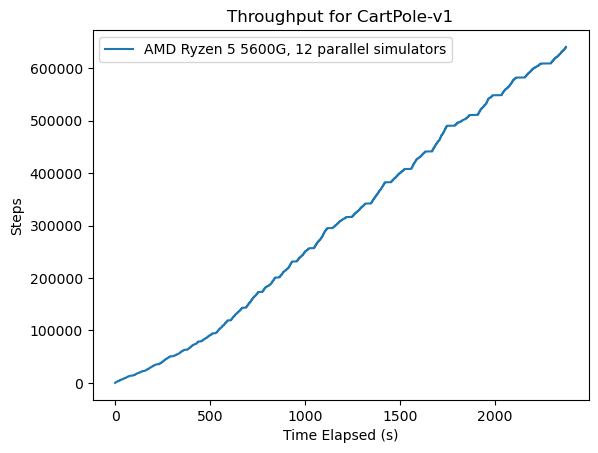

In [35]:
df = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
ORDER BY time
""").df()

df['elapsed_time'] = df['time'] - df['time'].min()

df.to_csv("saved_figures/cartpole_ryzen5_12threads.csv")

plt.plot(df['elapsed_time'], df['num_steps'], label='AMD Ryzen 5 5600G, 12 parallel simulators')

plt.ylabel('Steps')
plt.xlabel('Time Elapsed (s)')
plt.title("Throughput for CartPole-v1")
plt.legend()

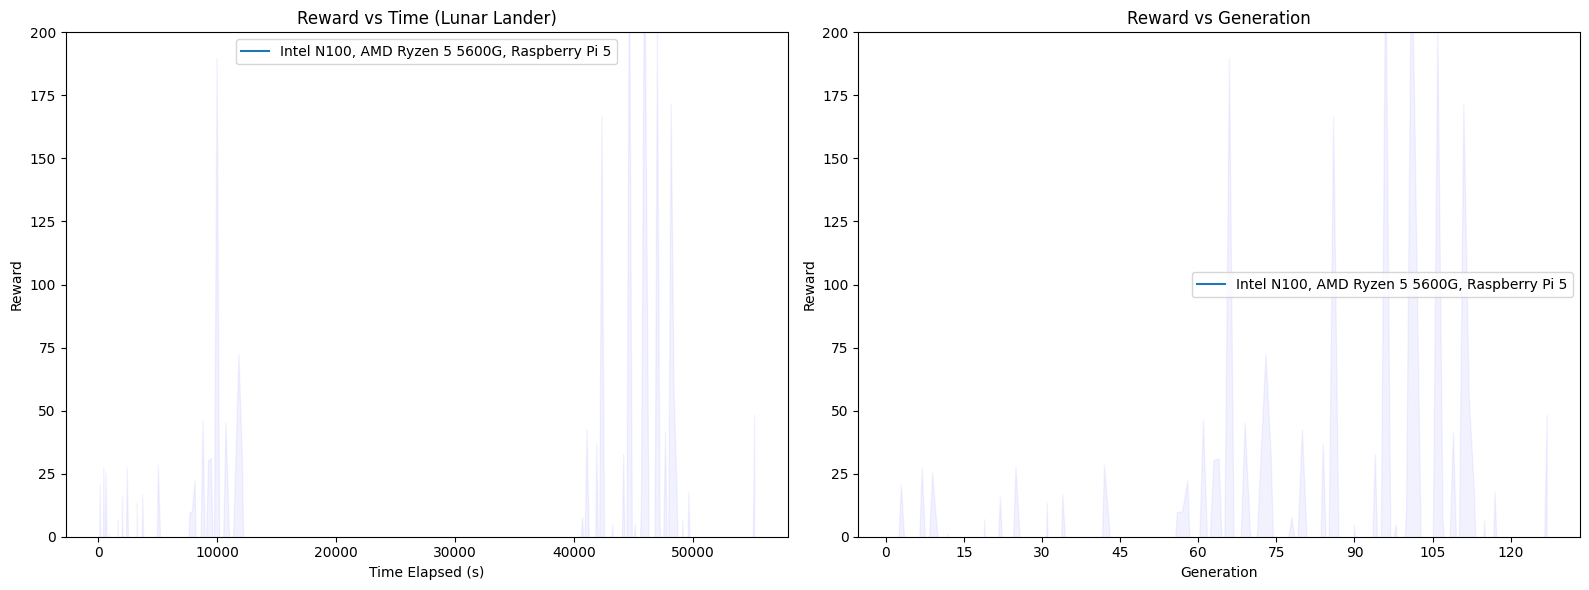

In [8]:
import matplotlib.pyplot as plt
import duckdb
import matplotlib.ticker as ticker

# Query to get the data
df = duckdb.query("""
WITH 
cumulative_reward AS
(
    SELECT generation, SUM(reward) AS cumulative_reward
    FROM db.public.training
    GROUP BY generation, team_id
    ORDER BY cumulative_reward DESC
), 
reward_by_generation AS
(
    SELECT generation,
           MIN(cumulative_reward) AS min_cumulative_reward, 
           AVG(cumulative_reward) AS avg_cumulative_reward, 
           MAX(cumulative_reward) AS max_cumulative_reward
    FROM cumulative_reward
    JOIN db.public.time_monitor USING (generation)
    GROUP BY generation
)
SELECT * FROM reward_by_generation
JOIN db.public.time_monitor USING (generation)
""").df()

df['time_elapsed'] = df['time'] - df['time'].min()

# Sort values by time_elapsed
df.sort_values(by=['time_elapsed'], inplace=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Reward vs Time Elapsed
ax1.fill_between(df['time_elapsed'], 
                 df['min_cumulative_reward'], 
                 df['max_cumulative_reward'], 
                 color='blue', alpha=0.05)
ax1.plot(df['time_elapsed'], df['avg_cumulative_reward'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")
ax1.set_ylabel('Reward')
ax1.set_xlabel('Time Elapsed (s)')
ax1.set_title("Reward vs Time (Lunar Lander)")
ax1.set_ylim(0, 200)
ax1.legend()

# Plot Reward vs Generation
ax2.plot(df['generation'], df['avg_cumulative_reward'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")
ax2.fill_between(df['generation'], 
                 df['min_cumulative_reward'], 
                 df['max_cumulative_reward'], 
                 color='blue', alpha=0.05)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Reward')
ax2.set_title("Reward vs Generation")
ax2.set_ylim(0, 200)
ax2.legend()
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Adjust layout
plt.tight_layout()
plt.show()


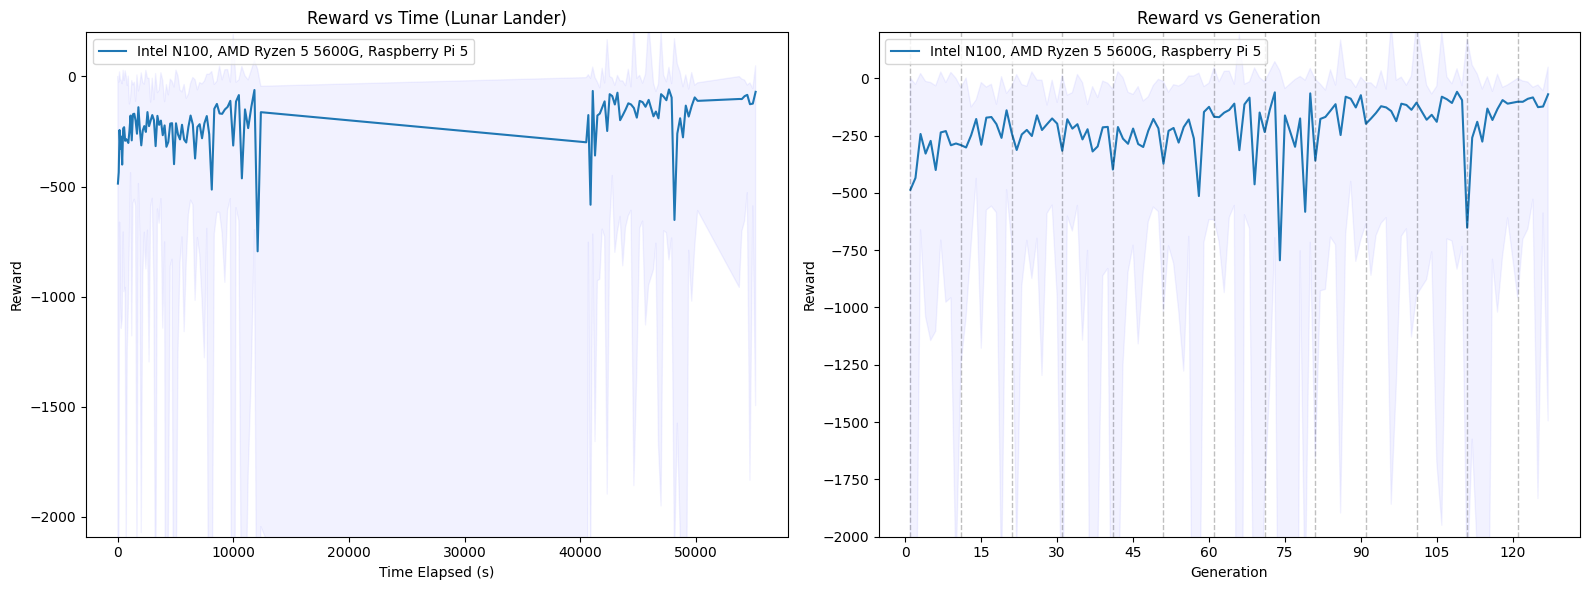

In [9]:
import matplotlib.pyplot as plt
import duckdb
import matplotlib.ticker as ticker

# Query to get the data
df = duckdb.query("""
WITH 
cumulative_reward AS
(
    SELECT generation, SUM(reward) AS cumulative_reward
    FROM db.public.training
    GROUP BY generation, team_id
    ORDER BY cumulative_reward DESC
), 
reward_by_generation AS
(
    SELECT generation,
           MIN(cumulative_reward) AS min_cumulative_reward, 
           AVG(cumulative_reward) AS avg_cumulative_reward, 
           MAX(cumulative_reward) AS max_cumulative_reward
    FROM cumulative_reward
    JOIN db.public.time_monitor USING (generation)
    GROUP BY generation
)
SELECT * FROM reward_by_generation
JOIN db.public.time_monitor USING (generation)
""").df()

df['time_elapsed'] = df['time'] - df['time'].min()

# Sort values by time_elapsed
df.sort_values(by=['time_elapsed'], inplace=True)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Reward vs Time Elapsed
ax1.fill_between(df['time_elapsed'], 
                 df['min_cumulative_reward'], 
                 df['max_cumulative_reward'], 
                 color='blue', alpha=0.05)
ax1.plot(df['time_elapsed'], df['avg_cumulative_reward'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")
ax1.set_ylabel('Reward')
ax1.set_xlabel('Time Elapsed (s)')
ax1.set_title("Reward vs Time (Lunar Lander)")
ax1.set_ylim(-2090, 200)
ax1.legend()

# Plot Reward vs Generation
ax2.plot(df['generation'], df['avg_cumulative_reward'], label="Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5")
ax2.fill_between(df['generation'], 
                 df['min_cumulative_reward'], 
                 df['max_cumulative_reward'], 
                 color='blue', alpha=0.05)
ax2.set_xlabel('Generation')
ax2.set_ylabel('Reward')
ax2.set_title("Reward vs Generation")
ax2.set_ylim(-2000, 200)
ax2.legend()
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Add vertical dashed lines every 10 generations
for gen in range(1, int(df['generation'].max()) + 1, 10):
    ax2.axvline(x=gen, color='black', alpha=0.25, linestyle='--', linewidth=1)

# Adjust layout
plt.tight_layout()
plt.show()


Text(0.5, 0, 'Generation')

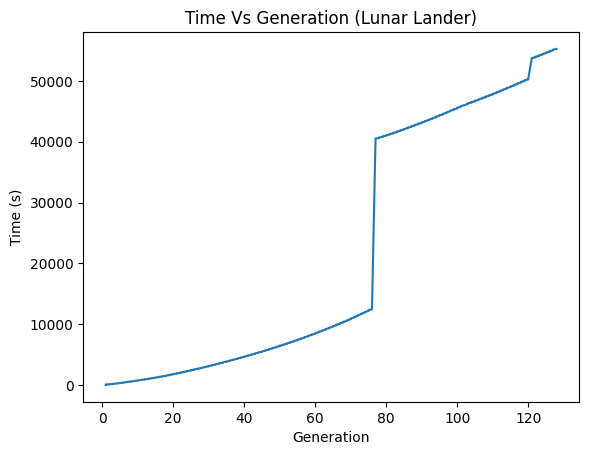

In [10]:
import matplotlib.pyplot as plt

df = duckdb.query("""
SELECT * FROM db.public.training
ORDER BY generation, time
""").df()

df['time_elapsed'] = df['time'] - df['time'].min()

plt.plot(df['generation'], df['time_elapsed'], label="AMD Ryzen 5 5600G")
plt.title("Time Vs Generation (Lunar Lander)")
plt.ylabel("Time (s)")
plt.xlabel("Generation")